# Baseline Model

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import os
import pathlib

sns.set()
pd.set_option('display.max_rows',500)

from trav_lib.visualize import plot_correlation_matrix_heat_map
from trav_lib.evaluate import get_confusion_matrix, evaluate_model
from trav_lib.utility import output_model

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_dir = pathlib.Path().resolve().parent / 'data'

data_raw = data_dir / 'raw'
data_interim = data_dir / 'interim'
data_external = data_dir / 'external'
data_processed = data_dir / 'processed'

model_dir = pathlib.Path().resolve().parent / 'models'

In [3]:
train = pd.read_parquet(data_interim / 'train.parquet')
test = pd.read_parquet(data_interim / 'test.parquet')

In [4]:
target_col = 'is_fraud'
date_col = 'transaction_dt'
trans_cat_cols = ['product_cd','card1','card2','card3','card4','card5','card6','addr1','addr2',
                  'p_emaildomain','r_emaildomain','m1','m2','m3','m4','m5','m6','m7','m8','m9']
trans_num_cols = list(train.loc[:,:'v339'].columns.drop([target_col] + trans_cat_cols + [date_col]))

ident_cat_cols = list(train.loc[:,'id_12':'identity_match'].columns)
ident_num_cols = list(train.loc[:,'id_01':'id_11'].columns)

cat_cols = trans_cat_cols + ident_cat_cols
num_cols = trans_num_cols + ident_num_cols

## Build model using only numeric values

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, make_scorer

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

def convert_to_str(df):
    df = df.astype(str)
    return(df)

str_transformer = FunctionTransformer(convert_to_str)

In [8]:
def group_values(s, top_n = 10, other_name = 'other'):

    counts = s.value_counts(dropna=False)
    if len(counts) > top_n:
        counts = counts.iloc[:top_n]
        usevals = list(counts.index)

        s = pd.Series(np.where(s.isin(usevals), s, other_name), index=s.index)

    return(s)

def group_values_df(df, top_n = 10, other_name = 'other'):
    
    df2 = df.copy()
    
    for col in df2.columns:
        df2[col] = group_values(df2[col], top_n, other_name)
        
    return(df2)

In [9]:
group_transformer = FunctionTransformer(group_values_df) 

train_cat = train[cat_cols].iloc[:1000]

train_cat_grouped = group_transformer.fit_transform(train_cat)

train_cat_grouped.head()

,product_cd,card1,card2,card3,card4,card5,card6,addr1,addr2,p_emaildomain,r_emaildomain,m1,m2,m3,m4,m5,m6,m7,m8,m9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,device_type,device_info,identity_match
transaction_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,W,other,other,150.0,discover,other,credit,315.0,87.0,other,other,T,T,T,M2,F,T,None,None,None,None,nan,NaN,None,None,NaN,NaN,nan,nan,NaN,NaN,None,NaN,NaN,NaN,None,None,None,other,other,NaN,other,None,None,None,None,None,None,other,0
2987001,W,other,other,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,other,None,None,None,M0,T,T,None,None,None,None,nan,NaN,None,None,NaN,NaN,nan,nan,NaN,NaN,None,NaN,NaN,NaN,None,None,None,other,other,NaN,other,None,None,None,None,None,None,other,0
2987002,W,other,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,other,T,T,T,M0,F,F,F,F,F,None,nan,NaN,None,None,NaN,NaN,nan,nan,NaN,NaN,None,NaN,NaN,NaN,None,None,None,other,other,NaN,other,None,None,None,None,None,None,other,0
2987003,W,other,other,150.0,mastercard,117.0,debit,other,87.0,yahoo.com,other,None,None,None,M0,T,F,None,None,None,None,nan,NaN,None,None,NaN,NaN,nan,nan,NaN,NaN,None,NaN,NaN,NaN,None,None,None,other,other,NaN,other,None,None,None,None,None,None,other,0
2987004,H,other,514.0,150.0,mastercard,102.0,credit,other,87.0,gmail.com,other,None,None,None,None,None,None,None,None,None,NotFound,nan,-480.0,New,NotFound,166.0,NaN,542.0,other,NaN,NaN,None,NaN,NaN,NaN,None,New,NotFound,Android 7.0,other,32.0,other,match_status:2,T,F,T,T,mobile,other,1


## Estimate proper n_estimators and learning rate to use with dataset
Learning rate = .1 and n_estimators = 100 seems like a reasonable starting point for model development, this was chosen based on looking at only the numerical features without any preprocessing

This will be revisited from time to time as features are added and eventually optimized in the final model

In [42]:
%%time

X_train = train[num_cols].iloc[:300000]
y_train = train[target_col].iloc[:300000]

X_test = train[num_cols].iloc[400000:]
y_test = train[target_col].iloc[400000:]

eval_results = []

params3 = {
    'n_estimators':[100,200,300],
    'learning_rate':[.01,.05, .1, .3]
}

for p in ParameterGrid(params3):
    model2 = XGBClassifier(**p, verbosity=0, use_label_encoder=False, eval_metric='auc', tree_method='hist')
    
    model2.fit(X_train, y_train, 
               eval_set = [(X_train, y_train), (X_test, y_test)],
               eval_metric='auc',
               verbose = False
              )

    evals_result = model2.evals_result()
    evals_result2 = pd.DataFrame({'train':evals_result['validation_0']['auc'],
                                  'test':evals_result['validation_1']['auc']})
    eval_results.append((p, evals_result2))

Wall time: 7min 28s


{'learning_rate': 0.01, 'n_estimators': 100} Max test auc: 0.816226


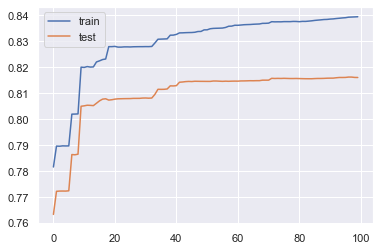

{'learning_rate': 0.01, 'n_estimators': 200} Max test auc: 0.845499


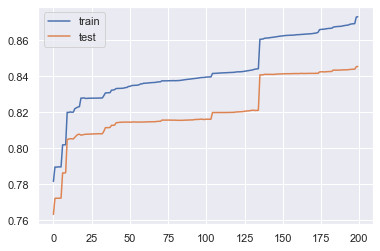

{'learning_rate': 0.01, 'n_estimators': 300} Max test auc: 0.854883


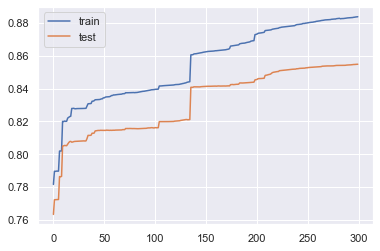

{'learning_rate': 0.05, 'n_estimators': 100} Max test auc: 0.86709


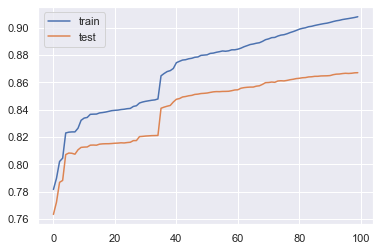

{'learning_rate': 0.05, 'n_estimators': 200} Max test auc: 0.874811


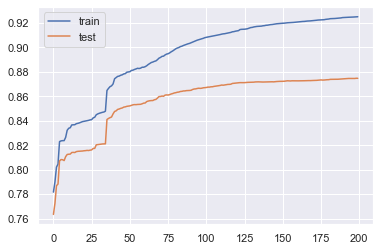

{'learning_rate': 0.05, 'n_estimators': 300} Max test auc: 0.875249


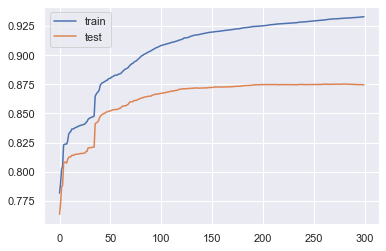

{'learning_rate': 0.1, 'n_estimators': 100} Max test auc: 0.874773


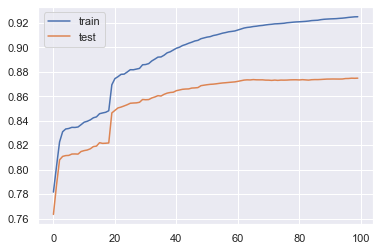

{'learning_rate': 0.1, 'n_estimators': 200} Max test auc: 0.874872


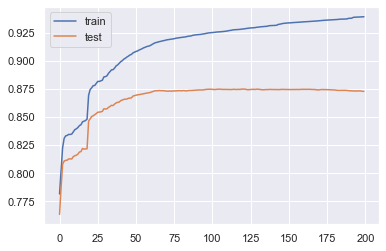

{'learning_rate': 0.1, 'n_estimators': 300} Max test auc: 0.874872


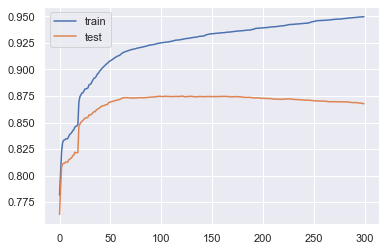

{'learning_rate': 0.3, 'n_estimators': 100} Max test auc: 0.864484


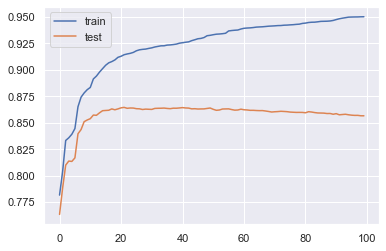

{'learning_rate': 0.3, 'n_estimators': 200} Max test auc: 0.864484


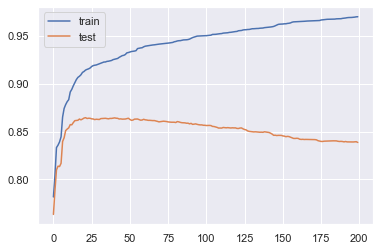

{'learning_rate': 0.3, 'n_estimators': 300} Max test auc: 0.864484


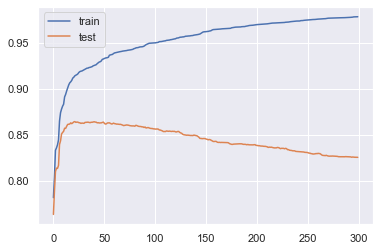

In [43]:
for p, df in eval_results:
    print(p, 'Max test auc:', df['test'].max())
    df.plot()
    plt.show()

## Validation Strategies
1. <s>Use first 5 months, predict 6th month</s>
2. <s>Use first 3 months, predict 5th and 6th months</s>
3. Time Series Split Cross Validation with 100000 transaction gap (roughly 1 month)

In [10]:
usecols = num_cols + cat_cols

X = train[usecols]
y = train[target_col]

tscv = TimeSeriesSplit(3, gap = 100000)

In [11]:
%%time

cat_pipe = Pipeline([
    ('str', str_transformer),
    ('grouping',group_transformer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])

use_num_cols = [col for col in num_cols if col in X.columns]
use_cat_cols = [col for col in cat_cols if col in X.columns]

# transformers = [('num',num_pipe,use_num_cols),
#                 ('cat',cat_pipe,use_cat_cols)]

transformers = [('cat',cat_pipe,use_cat_cols)]

preprocessor = ColumnTransformer(transformers, remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', tree_method = 'hist'))
])

params = {
    'xgb__max_depth':stats.randint(2,25),
    'xgb__n_estimators':[100], #stats.randint(20,100),
    'xgb__learning_rate': [.1], # list(np.logspace(np.log10(.01),np.log10(.5),1000)),
    'xgb__subsample': [.7, .8, .9, 1], # stats.uniform(.8,1),
    'xgb__colsample_bytree':[.7, .8, .9, 1], # stats.uniform(.1,1),
    'xgb__colsample_bylevel':[.7, .8, .9, 1], # stats.uniform(.1,1),
    'xgb__min_child_weight':np.logspace(np.log10(1),np.log10(100),1000)
}

grid = RandomizedSearchCV(
    pipe,
    params,
    cv=tscv,
    scoring=roc_scorer,
    n_iter = 2,
    verbose = 10,
    refit = True,
    n_jobs = -1
)


# # grid = grid.fit(X_train,y_train)
grid = grid.fit(X,y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Wall time: 6min 32s


In [12]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bylevel,param_xgb__colsample_bytree,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,177.396466,77.831322,20.839368,12.657690,0.7,0.9,0.1,24,48.4937,100,0.9,"{'xgb__colsample_bylevel': 0.7, 'xgb__colsampl...",0.874118,0.885431,0.887808,0.882452,0.005973,1
1,137.421424,63.218518,29.613567,13.982255,0.7,0.7,0.1,4,72.0872,100,0.7,"{'xgb__colsample_bylevel': 0.7, 'xgb__colsampl...",0.870536,0.876274,0.874892,0.873901,0.002445,2


In [41]:
%%time

notes = """"""

cv_metric = grid.best_score_
pred_proba = grid.predict_proba(test[usecols])[:,1]
predictions = pd.DataFrame({'TransactionID':test.index, 'isFraud':pred_proba})

output_model(grid.best_estimator_, predictions, model_dir, cv_metric, notes)

Wall time: 35.5 s
